In [3]:
import numpy as np
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
import os 
import numpy as np
from sklearn.cluster import DBSCAN

In [4]:
year = 2018
month=1
day=1
#data/2018/RR_IDF300x300_20180101.npy
path = os.path.join(os.path.dirname(os.getcwd()),'data','{:04d}'.format(year))
file = 'RR_IDF300x300_{:04d}{:02d}{:02d}.npy'.format(year,month,day)
file = os.path.join(path,file)

RR = np.load(file)/100.0
RR[RR < 0]=np.nan


In [5]:
def dtw_distance(x, y):
    distance, _ = fastdtw(x, y)
    return distance

## approche par PDynamique

In [107]:
def calculate_distance_matrix(RR=RR, x_start=0, x_end=10, y_start=0, y_end=10, distance_function=dtw_distance):
    selected_data = RR[:, x_start:x_end, y_start:y_end]
    
    num_series = selected_data.shape[1] * selected_data.shape[2]
    
    # Initialisation de la matrice des distances
    distance_matrix = np.zeros((num_series, num_series))
    
    # Remplissage de la matrice des distances
    for i in range(num_series):
        for j in range(i + 1, num_series):  # Pas besoin de calculer la diagonale et symétrique
            x_i, y_i = divmod(i, selected_data.shape[2])
            x_j, y_j = divmod(j, selected_data.shape[2])
            ts1 = selected_data[:, x_i, y_i]
            ts2 = selected_data[:, x_j, y_j]
            distance = distance_function(ts1, ts2)
            distance_matrix[i, j] = distance_matrix[j, i] = distance
    
    return distance_matrix


44.75999999999992 28.067681999999994


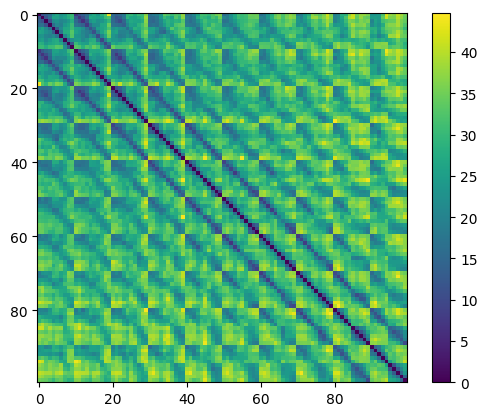

In [108]:
distance_matrix = calculate_distance_matrix(RR, 0, 10, 0, 10, dtw_distance)
print(distance_matrix.max(),distance_matrix.mean())
plt.imshow(distance_matrix)
plt.colorbar()

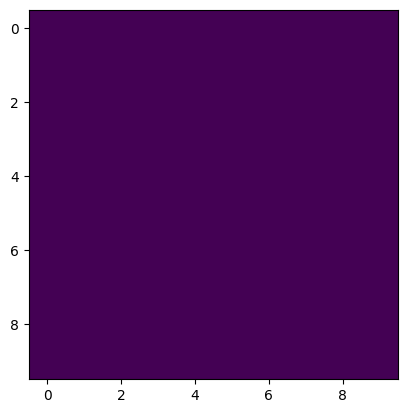

In [112]:
dbscan_dynamic = DBSCAN(eps=30, min_samples=4, metric='precomputed')
dbscan_dynamic.fit(distance_matrix)
labels=dbscan_dynamic.labels_
plt.imshow(labels.reshape(10,10))

## approche classic par DBSCAN SKLEARN

In [4]:
latitude_max=5
longitude_max=5
step=5
width=10

In [5]:
dbscan = DBSCAN(eps=20, min_samples=2, metric=dtw_distance)

# Adapter la taille et les indices en fonction de la structure de RR
dict_clusters = {}
dict_labels = {}

for i in range(longitude_max):
    for j in range(latitude_max):
        data = RR[:, i*step:width+i*step, j*step:width+j*step].reshape(-1, 288) 
        dbscan.fit(data)
        cluster_key = f"cluster({i},{j})"
        label_key = f"labels({i},{j})"
        dict_clusters[cluster_key] = dbscan
        dict_labels[label_key] = dbscan.labels_.reshape(width, width)



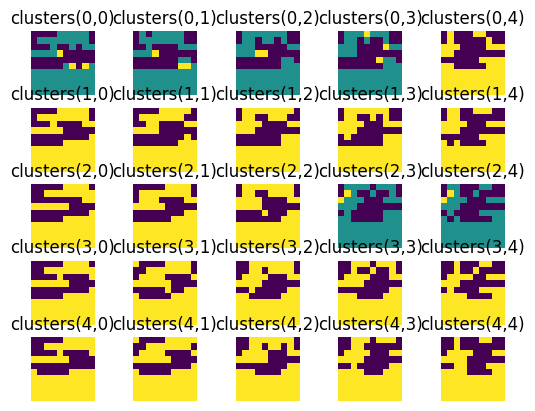

In [6]:
# Create a 2x2 subplot grid
fig, axs = plt.subplots(longitude_max, latitude_max)  # 2 rows, 2 columns

# Display images on each subplot
for i in range(longitude_max):
    for j in range(latitude_max):
        axs[i, j].imshow(dict_labels[f"labels({i},{j})"])
        axs[i, j].set_title(f'clusters({i},{j})')
        axs[i, j].axis('off')  # Hide axes for cleaner look

plt.show()

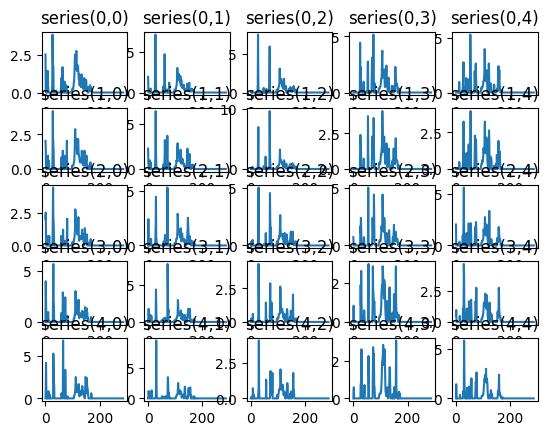

In [7]:
# Create a 2x2 subplot grid
fig, axs = plt.subplots(longitude_max, latitude_max)  

# Display images on each subplot
for i in range(longitude_max):
    for j in range(latitude_max):
        axs[i, j].plot(range(RR.shape[0]),RR[:, i*5, j*5])
        axs[i, j].set_title(f'series({i},{j})')
    

## Sliding window

In [6]:
longitude_max = 2 
latitude_max = 2 
step = 5 
width = 10  

In [7]:
dbscan = DBSCAN(eps=20, min_samples=2, metric=dtw_distance)

# Adapter la taille et les indices en fonction de la structure de RR
dict_clusters = {}
dict_labels = {}
core_points = {}

for i in range(longitude_max):
    for j in range(latitude_max):
        data = RR[:, i*step:width+i*step, j*step:width+j*step].reshape(-1, 288) 
        dbscan.fit(data)
        cluster_key = f"cluster({i},{j})"
        label_key = f"labels({i},{j})"
        core_points_key=f"core_points({i},{j})"
        dict_clusters[cluster_key] = dbscan
        dict_labels[label_key] = dbscan.labels_.reshape(width, width)
        core_points[core_points_key] = dbscan.core_sample_indices_



In [8]:
print(dict_labels)
print(core_points)

{'labels(0,0)': array([[-1, -1, -1, -1,  0,  0,  0,  0,  0, -1],
       [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
       [-1, -1, -1,  0, -1, -1,  0, -1,  0,  0],
       [ 0,  0,  0,  0,  1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1,  0,  1, -1,  1,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0]], dtype=int64), 'labels(0,1)': array([[-1,  0, -1,  0,  0,  0,  0,  0, -1, -1],
       [-1,  0,  0,  0,  0,  0,  0,  0, -1, -1],
       [-1, -1,  0, -1, -1, -1, -1,  0,  0,  0],
       [ 0,  0,  0,  1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1,  0,  0, -1],
       [-1, -1, -1, -1, -1, -1, -1,  1,  1,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,

a aprtir de la il faut forcer l'algo a prendre de valeur de plus en plus grande pour forcer une separation indicielle, et essai de faire un regroupement par retour sur les point core